# Landsat-8 Cloud Statistics

In [1]:
# Suppress Warning Messages
import warnings
warnings.filterwarnings('ignore')

# Load Data Cube Configuration
from odc_gee import earthengine
dc = earthengine.Datacube(app='Cloud_Statistics')

# Import Data Cube API
import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi()

# Import Data Cube Utilities
import datacube
from utils.data_cube_utilities.clean_mask import landsat_clean_mask_invalid, landsat_qa_clean_mask
from utils.data_cube_utilities.dc_display_map import display_map
from utils.data_cube_utilities.dc_rgb import rgb

# Import Common Utilities
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd

In [2]:
# Define the Product and Platform
# This data is indexed from Google Earth Engine data sources

product = "ls8_google"
platform = "LANDSAT_8"

In [3]:
# Select a Latitude-Longitude point for the center of the analysis region
# Select the size of the box (in degrees) surrounding the center point

# Mombasa, Kenya
# lat_long = (-4.03, 39.62)
# box_size_deg = 0.15

# Calculates the latitude and longitude bounds of the analysis box
# latitude = (lat_long[0]-box_size_deg/2, lat_long[0]+box_size_deg/2)
# longitude = (lat_long[1]-box_size_deg/2, lat_long[1]+box_size_deg/2)

# Sydney Cricket Ground
# latitude = (-33.8951, -33.8902)
# longitude = (151.2219, 151.2276)

# Suva, Fiji
# latitude = (-18.1725, -18.0492) 
# longitude = (178.3881, 178.5190) 

# Bua Bay, Fiji
latitude = (-17.0069, -16.7447) 
longitude = (178.4270, 178.6750) 

In [4]:
# Select a time range
# The inputs require a format (Min,Max) using this date format (YYYY-MM-DD)
# The Landsat-8 allowable time range is: 2013-04-07 to current
time_extents = ('2021-01-01', '2021-06-01')

In [5]:
# The code below renders a map that can be used to view the region.
# It is possible to find new regions using the map below. 
# Use your mouse to zoom in/out to explore new regions
# Click on the map to view Lat-Lon coordinates of any location that could define the region boundary

display_map(latitude,longitude)

## Calculate cloud coverage percentage for each pixel 

In [6]:
# Create a custom cloud coverage table here

def build_cloud_coverage_table_landsat(product,platform,collection,level,
                                       latitude,longitude,time=None,dc=None,
                                       extra_band='green',extra_load_params={}):
    
    dc = dc if dc is not None else datacube.Datacube(app="")

    load_params = dict(product=product,
                       latitude=latitude,
                       longitude=longitude,
                       measurements=[extra_band, 'pixel_qa'],
                       **extra_load_params)

    if time is not None:
        load_params["time"] = time

    landsat_dataset = dc.load(**load_params).persist()
    
    dates = [dt.astype('datetime64[D]') for dt in landsat_dataset.time.values]
        
    clean_masks = landsat_qa_clean_mask(landsat_dataset, platform=platform,
                                        collection=collection, level=level) & \
                  landsat_clean_mask_invalid(landsat_dataset, platform, collection, level)
    clean_percent = [clean_mask.mean()*100 for clean_mask in clean_masks.values]
    clean_count = list(map(np.sum, clean_masks.values))
    
    nodata_masks = xr.full_like(clean_masks, False)
    band_nodata_values = dc.list_measurements().loc[product, 'nodata']
    if band_nodata_values is not None:
        for data_var in landsat_dataset.values():
            band_nodata_masks = data_var == data_var.attrs['nodata']
            nodata_masks = nodata_masks | band_nodata_masks
    nodata_percent = [nodata_mask.mean()*100 for nodata_mask in nodata_masks.values]
    
    cloud_masks = (~clean_masks & ~nodata_masks)
    cloud_percent = [cloud_mask.mean()*100 for cloud_mask in cloud_masks.values]
            
    total_count = list(map(np.sum, ~nodata_masks.values))

    data = {"Date": dates,"Clean_percent": clean_percent,"Cloud_percent": cloud_percent,
            "NoData_percent": nodata_percent,"Clean_count": clean_count,"Total_count": total_count}

    return (landsat_dataset,
            pd.DataFrame(data=data, columns=list(data.keys())),
            cloud_masks, nodata_masks, clean_masks)

In [7]:
# Load the metadata for the given region and time period
landsat_dataset, coverage_table = build_cloud_coverage_table_landsat(dc=dc,
                                                                     product=product,
                                                                     platform=platform,
                                                                     collection='c2',
                                                                     level='l2',
                                                                     latitude=latitude,
                                                                     longitude=longitude,
                                                                     time=time_extents,
                                                                     extra_band='green')[0:2]

## Create a table of cloud coverage percentage for each date
This table displays data for each time slice in the cube (starting at an index=0). The "clean percent" is the percent of pixels WITHOUT clouds. So, low numbers are cloudy scenes and high numbers are clearer scenes. The "Clean_count" is the number of clear pixels in the scene and the "Total_count" is the total number of pixels in the scene.

Typically, there is a separation of 16 days between Landsat-8 views for a single location. When there is significant cloud cover, scenes may be missing from time series due to issues with processing and geolocation.

In [8]:
pd.set_option('display.max_rows', len(coverage_table))
coverage_table

,Date,Clean_percent,Cloud_percent,NoData_percent,Clean_count,Total_count
0,2021-01-02,18.298511,81.701489,0.000000,163979,896133
1,2021-01-18,88.947288,11.050145,0.002567,797086,896110
2,2021-02-03,0.000000,100.000000,0.000000,0,896133
3,2021-02-19,27.555173,72.444827,0.000000,246931,896133
4,2021-03-07,92.932411,7.067366,0.000223,832798,896131
5,2021-03-23,30.308224,69.691776,0.000000,271602,896133
6,2021-04-08,39.357997,60.627050,0.014953,352700,895999
7,2021-04-24,86.626650,13.373350,0.000000,776290,896133
8,2021-05-10,65.255715,34.744285,0.000000,584778,896133
9,2021-05-26,71.695385,28.279173,0.025443,642486,895905


## Create a plot of cloud coverage percentage for each date
The y-axis is the "clean percentage" from the table above.

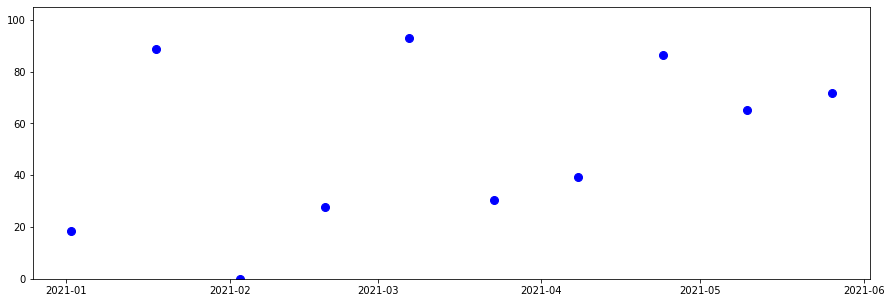

In [9]:
plt.figure(figsize = (15,5))
plt.plot(coverage_table["Date"].values, coverage_table["Clean_percent"].values, 'bo', markersize=8)
plt.ylim([0, 105])
plt.show()

## Review an RGB scene for a selected time slice

In [10]:
# Load the data to create an RGB image
landsat_dataset = dc.load(latitude=latitude,longitude=longitude,platform=platform,time=time_extents,
                          product=product,measurements=['red', 'green', 'blue', 'nir', 'swir1', 'swir2']) 

In [14]:
# Select one of the time slices and create an output image. 

# Time slices are numbered from 0 to x and shown in the summary table above
# Review the clean_percentage values to select scenes with few clouds
# Clouds will be visible in WHITE for an output image

slice = 4

In [15]:
# Collection 2 needs scale and offset applied for better color rendering
scale = lambda da: (da*da.attrs['scale_factor'])+da.attrs['add_offset']

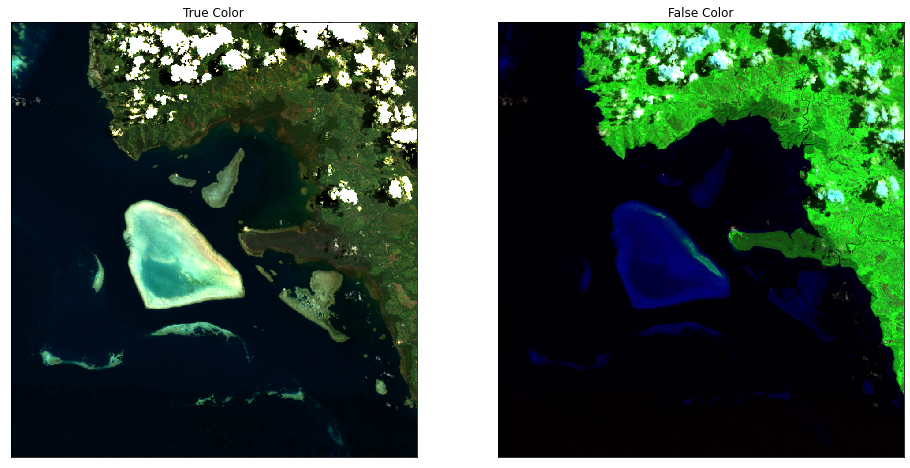

In [16]:
# Define the RGB image parameters
# True-Color = red, green, blue (this is the common true-color RGB image)
# False Color = swir2, nir, green (this is commonly used for Landsat data viewing)

true_rgb = landsat_dataset.isel(time=slice)[['red', 'green', 'blue']].map(scale).to_array()
false_rgb = landsat_dataset.isel(time=slice)[['swir2', 'nir', 'green']].map(scale).to_array()

# Define the plot settings and show the plots
# Users may want to alter the figure sizes or plot titles
# The "vmax" value controls the brightness of the images and can be adjusted 

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
true_rgb.plot.imshow(ax=ax[0], vmin=0, vmax=0.2)
false_rgb.plot.imshow(ax=ax[1], vmin=0, vmax=0.5)
ax[0].set_title('True Color'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title('False Color'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)
plt.show()